In [1]:
import pathlib
import pandas as pd
import plotnine as gg

from cytominer_eval import evaluate

In [2]:
# Load Data
path = pathlib.Path("profiles/NCP_PILOT_3/BR_NCP_PILOT_3/BR_NCP_PILOT_3_normalized_variable_selected.csv.gz")

df = pd.read_csv(path)

# Define important function arguments
meta_features = df.columns[df.columns.str.startswith("Metadata_")]
features = df.drop(meta_features, axis="columns").columns.tolist()

# Metadata_group is Metadata_line_condition + Metadata_plating_density
# Metadata_replicate is Metadata_compound_ID

print(df.shape)
df.head(5)

(384, 666)


,Metadata_Plate,Metadata_Well,Metadata_Assay_Plate_Barcode,Metadata_Plate_Map_Name,Metadata_well_position,Metadata_plating_density,Metadata_line_condition,Metadata_compound_ID,Metadata_replicate,Metadata_group,...,Neurites_Texture_InfoMeas2_RNA_20_03,Neurites_Texture_InverseDifferenceMoment_AGP_10_02,Neurites_Texture_InverseDifferenceMoment_AGP_20_02,Neurites_Texture_InverseDifferenceMoment_DNA_5_00,Neurites_Texture_SumAverage_AGP_10_00,Neurites_Texture_SumAverage_RNA_20_00,Neurites_Texture_SumVariance_Brightfield_10_03,Neurites_Texture_SumVariance_DNA_20_03,Neurites_Texture_SumVariance_ER_20_03,Neurites_Texture_Variance_AGP_5_02
0,BR_NCP_PILOT_3,A01,BR_NCP_PILOT_3,BR_NCP_PILOT_3,A01,2500,control,Untreated,Untreated,control_2500,...,0.68736,0.32353,0.38678,-1.333400,0.84262,0.43418,2.85160,-0.065548,1.05590,1.8216
1,BR_NCP_PILOT_3,A02,BR_NCP_PILOT_3,BR_NCP_PILOT_3,A02,10000,control,Untreated,Untreated,control_10000,...,1.42290,-1.49340,-1.79440,-0.053887,1.81270,2.02500,4.02830,-0.377890,1.38140,2.0071
2,BR_NCP_PILOT_3,A03,BR_NCP_PILOT_3,BR_NCP_PILOT_3,A03,2500,control,BRD-K79131256-001-17-9,BRD-K79131256-001-17-9,control_2500,...,0.83461,-0.84041,-0.30974,0.854620,1.29650,0.03451,0.90154,-0.094023,0.67013,2.7642
3,BR_NCP_PILOT_3,A04,BR_NCP_PILOT_3,BR_NCP_PILOT_3,A04,10000,control,BRD-K36207157-001-09-6,BRD-K36207157-001-09-6,control_10000,...,1.66050,-1.73520,-1.53300,-0.472280,1.98300,1.34460,1.43450,0.477740,1.00020,2.0469
4,BR_NCP_PILOT_3,A05,BR_NCP_PILOT_3,BR_NCP_PILOT_3,A05,2500,control,Untreated,Untreated,control_2500,...,2.11990,1.42280,1.51170,0.554710,-0.27509,-0.17327,0.92286,-0.267170,0.50922,1.2480


In [3]:
all_grit_results = []
for condition in df.Metadata_line_condition.unique():
    for plate_density in df.Metadata_plating_density.unique():
        subset_df = df.query("Metadata_line_condition == @condition").query("Metadata_plating_density == @plate_density")
        
        # First do this without any grouping (use the whole plate)
        control_perts = [
            "Untreated"
        ]

        replicate_groups = {
            "replicate_id": "Metadata_compound_ID",
            "group_id": "Metadata_group",
        }

        all_grit_results.append(
            evaluate(
                profiles=subset_df,
                features=features,
                meta_features=meta_features,
                replicate_groups=replicate_groups,
                operation="grit",
                grit_control_perts=control_perts,
            ).assign(condition=condition, plate_density=plate_density)
        )

In [4]:
full_grit_results_df = pd.concat(all_grit_results).sort_values(by="grit", ascending=False)

full_grit_results_df.plate_density = pd.Categorical(
    full_grit_results_df.plate_density.astype(str),
    categories=[str(x) for x in sorted(full_grit_results_df.plate_density.unique())]
)

print(full_grit_results_df.shape)
full_grit_results_df.head()

(40, 5)


,perturbation,group,grit,condition,plate_density
1,BRD-K21680192-300-14-4,deletion_5000,0.131401,deletion,5000
1,BRD-K21680192-300-14-4,control_7500,0.108044,control,7500
2,BRD-K36207157-001-09-6,deletion_2500,0.082487,deletion,2500
2,BRD-K36207157-001-09-6,control_7500,0.080734,control,7500
1,BRD-K21680192-300-14-4,deletion_7500,0.059791,deletion,7500


/Users/gway/miniconda3/envs/grit-benchmark/lib/python3.8/site-packages/plotnine/ggplot.py:727: PlotnineWarning: Saving 6.5 x 3 in image.
/Users/gway/miniconda3/envs/grit-benchmark/lib/python3.8/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: figures/BR_NCP_PILOT_3_grit.png


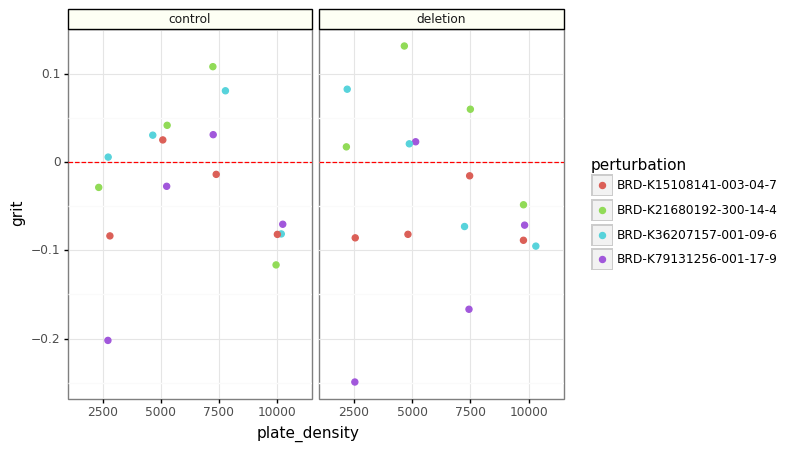

<ggplot: (396287513)>

In [5]:
grit_compare_gg = (
    gg.ggplot(full_grit_results_df.query("perturbation != 'Untreated'"), gg.aes(x="plate_density", y="grit", color="perturbation"))
    + gg.geom_jitter(width=0.15, size=2)
    + gg.facet_wrap("~condition")
    + gg.theme_bw()
    + gg.geom_hline(yintercept=0, linetype="dashed", color="red")
    + gg.theme(strip_background=gg.element_rect(colour="black", fill="#fdfff4"))
)

output_file = pathlib.Path("figures/BR_NCP_PILOT_3_grit.png")
grit_compare_gg.save(output_file, dpi=500, height=3, width=6.5)

grit_compare_gg